In [1]:
import re
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt

In [2]:
def select_gpu(N):
    gpus = tf.config.experimental.list_physical_devices('GPU')
    print(gpus)
    if gpus:
        try:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            tf.config.experimental.set_visible_devices(gpus[N], 'GPU')
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        except RuntimeError as e:
            print(e)    

In [3]:
select_gpu(2)
epochs = 10
batch_size = 8
model_name = 'bert-chinese'
embedding_path = '/home/Danny/pretrain_model/{}'.format(model_name)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU')]
3 Physical GPUs, 1 Logical GPUs


In [4]:
# 不用儲存article_id, 轉成list
def training_txt_to_list(path):
    with open(path, 'r') as f:
        txt = str(f.read())
    txt_list = txt.split('\n')
    text_label_list = list()
    tmp = list()
    for line in txt_list:
        if line == '--------------------':
            text_label_list.append(tmp)
            tmp = list()
            continue
        if line == '':
            continue
        tmp.append(line)
    x = list()
    y = list()
    for text_label in text_label_list:
        text = text_label[0]
        label = text_label[2:]
        label_list = ['O' for i in range(len(text))]
        for i in label:
            entity = i.split('\t')
            if int(entity[1]) > int(entity[2]):
                continue
            b = int(entity[1])
            label_list[b] = 'B-{}'.format(entity[-1])
            for j in range(int(entity[1])+1, int(entity[2])):
                label_list[j] = 'I-{}'.format(entity[-1])
        for i, j in enumerate(text):
            if j == '，' or j == '。' or j == '？':
                label_list[i] = j
                
        text_list = re.split('\uff0c|\u3002|\uff1f', text)
        for sentence in text_list:
            x.append([i for i in sentence])
        x = x[:-1]
            
        sentence = list()
        for i in label_list:
            if i == '，' or i == '。' or i == '？':
                y.append(sentence)
                sentence = list()
            else:
                sentence.append(i)
                
    return [x, y]

In [5]:
x1, y1 = training_txt_to_list('/home/Danny/AI-CUP-2020/datasets/stage1/SampleData_deid.txt')

In [6]:
x2, y2 = training_txt_to_list('/home/Danny/AI-CUP-2020/datasets/stage2/train_1_update.txt')

In [7]:
x4, y4 = training_txt_to_list('/home/Danny/AI-CUP-2020/datasets/stage4/train_2.txt')

In [8]:
x = x1 + x2 + x4
y = y1 + y2 + y4
print(len(x))
print(len(y))

76162
76162


In [9]:
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=42)
train_x, valid_x, train_y, valid_y = train_test_split(train_x, train_y, test_size=0.2, random_state=42)
print(len(train_x), len(train_y))
print(len(valid_x), len(valid_y))
print(len(test_x), len(test_y))

48743 48743
12186 12186
15233 15233


In [10]:
import kashgari
from kashgari.tasks.labeling import BiLSTM_CRF_Model
from kashgari.embeddings import BertEmbedding
kashgari.config.use_cudnn_cell = True
bert_embedding = BertEmbedding(embedding_path, 
                           sequence_length='auto',
                           trainable=True,
                           task='kashgari.LABELING', 
                          )
model = BiLSTM_CRF_Model(bert_embedding)
history = model.fit(train_x,
                    train_y,
                    valid_x,
                    valid_y,
                    epochs=epochs,
                    batch_size=batch_size,
                   )

2020-12-13 16:47:31,204 [DEBUG] kashgari - ------------------------------------------------
2020-12-13 16:47:31,205 [DEBUG] kashgari - Loaded transformer model's vocab
2020-12-13 16:47:31,205 [DEBUG] kashgari - config_path       : /home/Danny/pretrain_model/bert-chinese/bert_config.json
2020-12-13 16:47:31,205 [DEBUG] kashgari - vocab_path      : /home/Danny/pretrain_model/bert-chinese/vocab.txt
2020-12-13 16:47:31,206 [DEBUG] kashgari - checkpoint_path : /home/Danny/pretrain_model/bert-chinese/bert_model.ckpt
2020-12-13 16:47:31,207 [DEBUG] kashgari - Top 50 words    : ['[PAD]', '[unused1]', '[unused2]', '[unused3]', '[unused4]', '[unused5]', '[unused6]', '[unused7]', '[unused8]', '[unused9]', '[unused10]', '[unused11]', '[unused12]', '[unused13]', '[unused14]', '[unused15]', '[unused16]', '[unused17]', '[unused18]', '[unused19]', '[unused20]', '[unused21]', '[unused22]', '[unused23]', '[unused24]', '[unused25]', '[unused26]', '[unused27]', '[unused28]', '[unused29]', '[unused30]', '[

Epoch 1/10
6092/6092 [==============================] - 1358s 223ms/step - loss: 0.2109 - accuracy: 0.9847 - val_loss: 17.4025 - val_accuracy: 0.9883
Epoch 2/10
6092/6092 [==============================] - 1543s 253ms/step - loss: 0.0964 - accuracy: 0.9884 - val_loss: 14.2041 - val_accuracy: 0.9883
Epoch 3/10
6092/6092 [==============================] - 1443s 237ms/step - loss: 0.0768 - accuracy: 0.9889 - val_loss: 12.3072 - val_accuracy: 0.9850
Epoch 4/10
6092/6092 [==============================] - 1280s 210ms/step - loss: 0.0693 - accuracy: 0.9898 - val_loss: 11.3219 - val_accuracy: 0.9819
Epoch 5/10
6092/6092 [==============================] - 1263s 207ms/step - loss: 0.0626 - accuracy: 0.9902 - val_loss: 10.7374 - val_accuracy: 0.9842
Epoch 6/10
6092/6092 [==============================] - 1077s 177ms/step - loss: 0.0581 - accuracy: 0.9910 - val_loss: 10.4139 - val_accuracy: 0.9846
Epoch 7/10
6092/6092 [==============================] - 949s 156ms/step - loss: 0.0549 - accuracy: 0

In [11]:
model.evaluate(test_x, test_y)
model_path = 'model/{}-epoch-{}'.format(model_name, epochs)
model.save(model_path)

2020-12-13 19:41:23,713 [WARNING] kashgari - Sequence length is None, will use the max length of the samples, which is 65
2020-12-13 19:41:23,837 [DEBUG] kashgari - predict seq_length: None, input: (2, 15233, 65)


477/477 [==============================] - 56s 118ms/step


2020-12-13 19:42:25,468 [DEBUG] kashgari - predict output: (15233, 65)
2020-12-13 19:42:25,469 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]]



                precision    recall  f1-score   support

          time     0.7652    0.7608    0.7630       878
    profession     0.8571    0.3529    0.5000        17
         money     0.8200    0.9535    0.8817        43
        family     0.5833    0.6364    0.6087        11
          name     0.9286    0.8864    0.9070        88
      location     0.9362    0.8627    0.8980       102
      med_exam     0.7325    0.8582    0.7904       134
            ID     1.0000    0.4444    0.6154         9
       contact     0.6875    0.6111    0.6471        18
  organization     0.1667    0.5000    0.2500         2
     education     0.5000    0.5000    0.5000         2
        others     0.0000    0.0000    0.0000         1
clinical_event     0.0000    0.0000    0.0000         1

     micro avg     0.7816    0.7810    0.7813      1306
     macro avg     0.7857    0.7810    0.7803      1306



2020-12-13 19:42:36,614 [INFO] kashgari - model saved to /home/Danny/AI-CUP-2020/Danny/kashgari/model/bert-chinese-epoch-10


'/home/Danny/AI-CUP-2020/Danny/kashgari/model/bert-chinese-epoch-10'

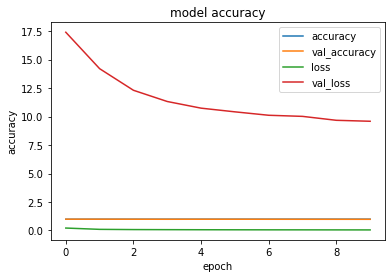

In [12]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy', 'val_accuracy', 'loss', 'val_loss'])
plt.show()

In [13]:
# 需要儲存article_id, 轉成dataframe
def predicting_txt_to_dataframe(path):    
    with open(path, 'r') as f:
        txt = str(f.read())
        txt_list = txt.split('\n')
    row_list = list()
    tmp_list = list()
    for row in txt_list:
        if row == '--------------------':
            tmp_list[0] = tmp_list[0].replace('article_id:', '')
            tmp_list[0] = int(tmp_list[0])
            row_list.append(tmp_list)
            tmp_list = list()
            continue
        if len(row) > 0:
            tmp_list.append(row)
    df = pd.DataFrame(row_list, columns=['article_id','text'])
    return df

In [14]:
def predict_NER(text):
    x_list = list()    
    text_list = re.split('\uff0c|\u3002|\uff1f', text)
    for article in text_list:
        x_list.append([i for i in article])
    y_list_list = model.predict(x_list)
    y_list = list()
    for sentence in y_list_list:
        for word in sentence:
            y_list.append(word)
        y_list.append('O') # append(，。？)
    y_list = y_list[:-1]
    return y_list

In [15]:
def output_NER(article_id, text, y_list):
    output_str = str()
    flag = False
    for i, j in enumerate(y_list):
        if j != 'O':
            if j[0] == 'B':
                start_position = i
                entity_type = j.split('-')[-1]
                flag = True
        elif j == 'O' and flag == True:
            end_position = i
            flag = False
            entity_text = text[start_position: end_position]
            entity = '{}\t{}\t{}\t{}\t{}\n'.format(article_id, start_position, end_position, entity_text, entity_type)  
            output_str += entity
    return output_str

In [16]:
df = predicting_txt_to_dataframe('/home/Danny/AI-CUP-2020/datasets/stage4/development_2.txt')
output_str = "article_id\tstart_position\tend_position\tentity_text\tentity_type\n"

for article_id, text in zip(df['article_id'], df['text']):
    x_list = [word for word in text]
    y_list = predict_NER(text)
    output_str += output_NER(article_id, text, y_list)

2020-12-13 19:42:36,802 [DEBUG] kashgari - predict seq_length: None, input: (2, 368, 29)


12/12 [==============================] - 1s 67ms/step


2020-12-13 19:42:42,846 [DEBUG] kashgari - predict output: (368, 29)
2020-12-13 19:42:42,847 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-13 19:42:42,850 [DEBUG] kashgari - predict seq_length: None, input: (2, 78, 33)


3/3 [==============================] - 0s 42ms/step


2020-12-13 19:42:47,844 [DEBUG] kashgari - predict output: (78, 33)
2020-12-13 19:42:47,845 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 0 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]]
2020-12-13 19:42:47,848 [DEBUG] kashgari - predict seq_length: None, input: (2, 159, 29)


5/5 [==============================] - 0s 50ms/step


2020-12-13 19:42:48,185 [DEBUG] kashgari - predict output: (159, 29)
2020-12-13 19:42:48,186 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-13 19:42:48,191 [DEBUG] kashgari - predict seq_length: None, input: (2, 329, 28)


11/11 [==============================] - 1s 56ms/step


2020-12-13 19:42:51,851 [DEBUG] kashgari - predict output: (329, 28)
2020-12-13 19:42:51,852 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-13 19:42:51,855 [DEBUG] kashgari - predict seq_length: None, input: (2, 227, 29)


8/8 [==============================] - 0s 54ms/step


2020-12-13 19:42:52,370 [DEBUG] kashgari - predict output: (227, 29)
2020-12-13 19:42:52,371 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 2 2 2]
 [0 1 1 ... 1 1 1]
 [0 7 4 ... 4 4 4]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-13 19:42:52,377 [DEBUG] kashgari - predict seq_length: None, input: (2, 295, 26)


10/10 [==============================] - 1s 54ms/step


2020-12-13 19:42:56,211 [DEBUG] kashgari - predict output: (295, 26)
2020-12-13 19:42:56,212 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 0 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-13 19:42:56,214 [DEBUG] kashgari - predict seq_length: None, input: (2, 183, 25)


6/6 [==============================] - 0s 49ms/step


2020-12-13 19:42:59,477 [DEBUG] kashgari - predict output: (183, 25)
2020-12-13 19:42:59,478 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 9 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-13 19:42:59,481 [DEBUG] kashgari - predict seq_length: None, input: (2, 126, 19)


4/4 [==============================] - 0s 40ms/step


2020-12-13 19:43:02,587 [DEBUG] kashgari - predict output: (126, 19)
2020-12-13 19:43:02,588 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 0 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-13 19:43:02,591 [DEBUG] kashgari - predict seq_length: None, input: (2, 117, 23)


4/4 [==============================] - 0s 44ms/step


2020-12-13 19:43:05,664 [DEBUG] kashgari - predict output: (117, 23)
2020-12-13 19:43:05,664 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-13 19:43:05,666 [DEBUG] kashgari - predict seq_length: None, input: (2, 91, 22)


3/3 [==============================] - 0s 37ms/step


2020-12-13 19:43:09,148 [DEBUG] kashgari - predict output: (91, 22)
2020-12-13 19:43:09,149 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-13 19:43:09,150 [DEBUG] kashgari - predict seq_length: None, input: (2, 63, 25)


2/2 [==============================] - 0s 27ms/step


2020-12-13 19:43:09,282 [DEBUG] kashgari - predict output: (63, 25)
2020-12-13 19:43:09,283 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-13 19:43:09,288 [DEBUG] kashgari - predict seq_length: None, input: (2, 259, 32)


9/9 [==============================] - 1s 58ms/step


2020-12-13 19:43:12,870 [DEBUG] kashgari - predict output: (259, 32)
2020-12-13 19:43:12,870 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 4 4 4]
 [0 1 1 ... 1 1 1]
 [0 7 4 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-13 19:43:12,873 [DEBUG] kashgari - predict seq_length: None, input: (2, 109, 20)


4/4 [==============================] - 0s 42ms/step


2020-12-13 19:43:16,094 [DEBUG] kashgari - predict output: (109, 20)
2020-12-13 19:43:16,095 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 0 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-13 19:43:16,097 [DEBUG] kashgari - predict seq_length: None, input: (2, 122, 22)


4/4 [==============================] - 0s 39ms/step


2020-12-13 19:43:16,333 [DEBUG] kashgari - predict output: (122, 22)
2020-12-13 19:43:16,333 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-13 19:43:16,336 [DEBUG] kashgari - predict seq_length: None, input: (2, 158, 40)


5/5 [==============================] - 0s 65ms/step


2020-12-13 19:43:19,705 [DEBUG] kashgari - predict output: (158, 40)
2020-12-13 19:43:19,706 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 2 2 2]]
2020-12-13 19:43:19,709 [DEBUG] kashgari - predict seq_length: None, input: (2, 218, 34)


7/7 [==============================] - 0s 58ms/step


2020-12-13 19:43:23,151 [DEBUG] kashgari - predict output: (218, 34)
2020-12-13 19:43:23,152 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-13 19:43:23,154 [DEBUG] kashgari - predict seq_length: None, input: (2, 103, 16)


4/4 [==============================] - 0s 36ms/step


2020-12-13 19:43:26,224 [DEBUG] kashgari - predict output: (103, 16)
2020-12-13 19:43:26,225 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 5 5 5]
 [0 1 1 ... 1 1 1]]
2020-12-13 19:43:26,231 [DEBUG] kashgari - predict seq_length: None, input: (2, 310, 40)


10/10 [==============================] - 1s 70ms/step


2020-12-13 19:43:27,036 [DEBUG] kashgari - predict output: (310, 40)
2020-12-13 19:43:27,037 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-13 19:43:27,039 [DEBUG] kashgari - predict seq_length: None, input: (2, 73, 22)


3/3 [==============================] - 0s 33ms/step


2020-12-13 19:43:27,214 [DEBUG] kashgari - predict output: (73, 22)
2020-12-13 19:43:27,215 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 3 2 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-13 19:43:27,223 [DEBUG] kashgari - predict seq_length: None, input: (2, 624, 50)


20/20 [==============================] - 2s 89ms/step


2020-12-13 19:43:32,613 [DEBUG] kashgari - predict output: (624, 50)
2020-12-13 19:43:32,614 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-13 19:43:32,619 [DEBUG] kashgari - predict seq_length: None, input: (2, 445, 35)


14/14 [==============================] - 1s 67ms/step


2020-12-13 19:43:36,669 [DEBUG] kashgari - predict output: (445, 35)
2020-12-13 19:43:36,669 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 3 ... 2 2 2]
 [0 0 0 ... 0 0 0]]
2020-12-13 19:43:36,676 [DEBUG] kashgari - predict seq_length: None, input: (2, 357, 34)


12/12 [==============================] - 1s 61ms/step


2020-12-13 19:43:37,511 [DEBUG] kashgari - predict output: (357, 34)
2020-12-13 19:43:37,512 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-13 19:43:37,515 [DEBUG] kashgari - predict seq_length: None, input: (2, 328, 49)


11/11 [==============================] - 1s 83ms/step


2020-12-13 19:43:41,580 [DEBUG] kashgari - predict output: (328, 49)
2020-12-13 19:43:41,581 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-13 19:43:41,584 [DEBUG] kashgari - predict seq_length: None, input: (2, 133, 59)


5/5 [==============================] - 0s 90ms/step


2020-12-13 19:43:46,914 [DEBUG] kashgari - predict output: (133, 59)
2020-12-13 19:43:46,915 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-13 19:43:46,917 [DEBUG] kashgari - predict seq_length: None, input: (2, 129, 23)


5/5 [==============================] - 0s 52ms/step


2020-12-13 19:43:47,258 [DEBUG] kashgari - predict output: (129, 23)
2020-12-13 19:43:47,259 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 0 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-13 19:43:47,262 [DEBUG] kashgari - predict seq_length: None, input: (2, 131, 30)


5/5 [==============================] - 0s 56ms/step


2020-12-13 19:43:52,423 [DEBUG] kashgari - predict output: (131, 30)
2020-12-13 19:43:52,425 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-13 19:43:52,429 [DEBUG] kashgari - predict seq_length: None, input: (2, 234, 34)


8/8 [==============================] - 1s 67ms/step


2020-12-13 19:43:53,068 [DEBUG] kashgari - predict output: (234, 34)
2020-12-13 19:43:53,070 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 2 2 2]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-13 19:43:53,072 [DEBUG] kashgari - predict seq_length: None, input: (2, 79, 33)


3/3 [==============================] - 0s 43ms/step


2020-12-13 19:43:53,302 [DEBUG] kashgari - predict output: (79, 33)
2020-12-13 19:43:53,302 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-13 19:43:53,305 [DEBUG] kashgari - predict seq_length: None, input: (2, 260, 37)


9/9 [==============================] - 1s 64ms/step


2020-12-13 19:43:58,145 [DEBUG] kashgari - predict output: (260, 37)
2020-12-13 19:43:58,145 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-13 19:43:58,148 [DEBUG] kashgari - predict seq_length: None, input: (2, 255, 35)


8/8 [==============================] - 0s 62ms/step


2020-12-13 19:43:58,738 [DEBUG] kashgari - predict output: (255, 35)
2020-12-13 19:43:58,738 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-13 19:43:58,741 [DEBUG] kashgari - predict seq_length: None, input: (2, 175, 41)


6/6 [==============================] - 0s 65ms/step


2020-12-13 19:44:02,805 [DEBUG] kashgari - predict output: (175, 41)
2020-12-13 19:44:02,805 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-13 19:44:02,809 [DEBUG] kashgari - predict seq_length: None, input: (2, 189, 31)


6/6 [==============================] - 0s 57ms/step


2020-12-13 19:44:06,193 [DEBUG] kashgari - predict output: (189, 31)
2020-12-13 19:44:06,194 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-13 19:44:06,199 [DEBUG] kashgari - predict seq_length: None, input: (2, 292, 31)


10/10 [==============================] - 1s 57ms/step


2020-12-13 19:44:06,866 [DEBUG] kashgari - predict output: (292, 31)
2020-12-13 19:44:06,867 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-13 19:44:06,870 [DEBUG] kashgari - predict seq_length: None, input: (2, 97, 38)


4/4 [==============================] - 0s 51ms/step


2020-12-13 19:44:10,150 [DEBUG] kashgari - predict output: (97, 38)
2020-12-13 19:44:10,151 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 2 2 2]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-13 19:44:10,156 [DEBUG] kashgari - predict seq_length: None, input: (2, 351, 56)


11/11 [==============================] - 1s 92ms/step


2020-12-13 19:44:14,163 [DEBUG] kashgari - predict output: (351, 56)
2020-12-13 19:44:14,164 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-13 19:44:14,169 [DEBUG] kashgari - predict seq_length: None, input: (2, 297, 46)


10/10 [==============================] - 1s 80ms/step


2020-12-13 19:44:17,929 [DEBUG] kashgari - predict output: (297, 46)
2020-12-13 19:44:17,929 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-13 19:44:17,932 [DEBUG] kashgari - predict seq_length: None, input: (2, 136, 21)


5/5 [==============================] - 0s 44ms/step


2020-12-13 19:44:21,212 [DEBUG] kashgari - predict output: (136, 21)
2020-12-13 19:44:21,213 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 4 4 4]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-13 19:44:21,216 [DEBUG] kashgari - predict seq_length: None, input: (2, 115, 42)


4/4 [==============================] - 0s 57ms/step


2020-12-13 19:44:24,521 [DEBUG] kashgari - predict output: (115, 42)
2020-12-13 19:44:24,522 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-13 19:44:24,524 [DEBUG] kashgari - predict seq_length: None, input: (2, 89, 23)


3/3 [==============================] - 0s 35ms/step


2020-12-13 19:44:24,709 [DEBUG] kashgari - predict output: (89, 23)
2020-12-13 19:44:24,710 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-13 19:44:24,714 [DEBUG] kashgari - predict seq_length: None, input: (2, 251, 52)


8/8 [==============================] - 1s 84ms/step


2020-12-13 19:44:28,579 [DEBUG] kashgari - predict output: (251, 52)
2020-12-13 19:44:28,580 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-13 19:44:28,582 [DEBUG] kashgari - predict seq_length: None, input: (2, 153, 20)


5/5 [==============================] - 0s 39ms/step


2020-12-13 19:44:28,848 [DEBUG] kashgari - predict output: (153, 20)
2020-12-13 19:44:28,848 [DEBUG] kashgari - predict output argmax: [[ 0  1  1 ...  1  1  1]
 [ 0  1  0 ...  1  1  1]
 [ 0  1  1 ... 22 22 22]
 ...
 [ 0  1  1 ...  1  1  1]
 [ 0  1  1 ...  1  1  1]
 [ 0  0  0 ...  0  0  0]]
2020-12-13 19:44:28,851 [DEBUG] kashgari - predict seq_length: None, input: (2, 169, 47)


6/6 [==============================] - 0s 74ms/step


2020-12-13 19:44:33,056 [DEBUG] kashgari - predict output: (169, 47)
2020-12-13 19:44:33,057 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-13 19:44:33,062 [DEBUG] kashgari - predict seq_length: None, input: (2, 324, 37)


11/11 [==============================] - 1s 66ms/step


2020-12-13 19:44:33,885 [DEBUG] kashgari - predict output: (324, 37)
2020-12-13 19:44:33,885 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 5 5 5]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-13 19:44:33,887 [DEBUG] kashgari - predict seq_length: None, input: (2, 157, 35)


5/5 [==============================] - 0s 56ms/step


2020-12-13 19:44:34,263 [DEBUG] kashgari - predict output: (157, 35)
2020-12-13 19:44:34,264 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-13 19:44:34,267 [DEBUG] kashgari - predict seq_length: None, input: (2, 191, 27)


6/6 [==============================] - 0s 53ms/step


2020-12-13 19:44:37,626 [DEBUG] kashgari - predict output: (191, 27)
2020-12-13 19:44:37,627 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-13 19:44:37,629 [DEBUG] kashgari - predict seq_length: None, input: (2, 115, 36)


4/4 [==============================] - 0s 53ms/step


2020-12-13 19:44:40,858 [DEBUG] kashgari - predict output: (115, 36)
2020-12-13 19:44:40,859 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-13 19:44:40,866 [DEBUG] kashgari - predict seq_length: None, input: (2, 529, 33)


17/17 [==============================] - 1s 64ms/step


2020-12-13 19:44:42,050 [DEBUG] kashgari - predict output: (529, 33)
2020-12-13 19:44:42,051 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-13 19:44:42,054 [DEBUG] kashgari - predict seq_length: None, input: (2, 217, 32)


7/7 [==============================] - 0s 57ms/step


2020-12-13 19:44:42,546 [DEBUG] kashgari - predict output: (217, 32)
2020-12-13 19:44:42,547 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-13 19:44:42,551 [DEBUG] kashgari - predict seq_length: None, input: (2, 186, 47)


6/6 [==============================] - 0s 76ms/step


2020-12-13 19:44:43,126 [DEBUG] kashgari - predict output: (186, 47)
2020-12-13 19:44:43,126 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-13 19:44:43,130 [DEBUG] kashgari - predict seq_length: None, input: (2, 410, 55)


13/13 [==============================] - 1s 93ms/step


2020-12-13 19:44:47,490 [DEBUG] kashgari - predict output: (410, 55)
2020-12-13 19:44:47,491 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-13 19:44:47,495 [DEBUG] kashgari - predict seq_length: None, input: (2, 347, 42)


11/11 [==============================] - 1s 74ms/step


2020-12-13 19:44:48,422 [DEBUG] kashgari - predict output: (347, 42)
2020-12-13 19:44:48,423 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-13 19:44:48,428 [DEBUG] kashgari - predict seq_length: None, input: (2, 524, 65)


17/17 [==============================] - 2s 108ms/step


2020-12-13 19:44:50,414 [DEBUG] kashgari - predict output: (524, 65)
2020-12-13 19:44:50,414 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-13 19:44:50,417 [DEBUG] kashgari - predict seq_length: None, input: (2, 182, 29)


6/6 [==============================] - 0s 52ms/step


2020-12-13 19:44:50,811 [DEBUG] kashgari - predict output: (182, 29)
2020-12-13 19:44:50,812 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-13 19:44:50,815 [DEBUG] kashgari - predict seq_length: None, input: (2, 163, 20)


6/6 [==============================] - 0s 43ms/step


2020-12-13 19:44:51,148 [DEBUG] kashgari - predict output: (163, 20)
2020-12-13 19:44:51,149 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 0 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-13 19:44:51,151 [DEBUG] kashgari - predict seq_length: None, input: (2, 97, 19)


4/4 [==============================] - 0s 37ms/step


2020-12-13 19:44:51,372 [DEBUG] kashgari - predict output: (97, 19)
2020-12-13 19:44:51,373 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-13 19:44:51,377 [DEBUG] kashgari - predict seq_length: None, input: (2, 189, 21)


6/6 [==============================] - 0s 49ms/step


2020-12-13 19:44:51,749 [DEBUG] kashgari - predict output: (189, 21)
2020-12-13 19:44:51,749 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 0 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-13 19:44:51,753 [DEBUG] kashgari - predict seq_length: None, input: (2, 320, 25)


10/10 [==============================] - 0s 43ms/step


2020-12-13 19:44:55,483 [DEBUG] kashgari - predict output: (320, 25)
2020-12-13 19:44:55,484 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 0 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-13 19:44:55,487 [DEBUG] kashgari - predict seq_length: None, input: (2, 301, 20)


10/10 [==============================] - 0s 47ms/step


2020-12-13 19:44:56,043 [DEBUG] kashgari - predict output: (301, 20)
2020-12-13 19:44:56,044 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 0 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-13 19:44:56,048 [DEBUG] kashgari - predict seq_length: None, input: (2, 82, 35)


3/3 [==============================] - 0s 45ms/step


2020-12-13 19:44:56,280 [DEBUG] kashgari - predict output: (82, 35)
2020-12-13 19:44:56,281 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-13 19:44:56,284 [DEBUG] kashgari - predict seq_length: None, input: (2, 192, 37)


6/6 [==============================] - 0s 52ms/step


2020-12-13 19:44:59,858 [DEBUG] kashgari - predict output: (192, 37)
2020-12-13 19:44:59,859 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 2 2 2]
 [0 1 3 ... 1 1 1]
 [0 1 1 ... 2 2 2]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-13 19:44:59,863 [DEBUG] kashgari - predict seq_length: None, input: (2, 264, 48)


9/9 [==============================] - 1s 81ms/step


2020-12-13 19:45:05,428 [DEBUG] kashgari - predict output: (264, 48)
2020-12-13 19:45:05,429 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-13 19:45:05,433 [DEBUG] kashgari - predict seq_length: None, input: (2, 247, 43)


8/8 [==============================] - 1s 69ms/step


2020-12-13 19:45:09,408 [DEBUG] kashgari - predict output: (247, 43)
2020-12-13 19:45:09,409 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-13 19:45:09,410 [DEBUG] kashgari - predict seq_length: None, input: (2, 120, 21)


4/4 [==============================] - 0s 38ms/step


2020-12-13 19:45:09,637 [DEBUG] kashgari - predict output: (120, 21)
2020-12-13 19:45:09,638 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 2 2 2]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-13 19:45:09,640 [DEBUG] kashgari - predict seq_length: None, input: (2, 49, 21)


2/2 [==============================] - 0s 24ms/step


2020-12-13 19:45:09,763 [DEBUG] kashgari - predict output: (49, 21)
2020-12-13 19:45:09,764 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-13 19:45:09,766 [DEBUG] kashgari - predict seq_length: None, input: (2, 104, 32)


4/4 [==============================] - 0s 46ms/step


2020-12-13 19:45:10,037 [DEBUG] kashgari - predict output: (104, 32)
2020-12-13 19:45:10,038 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-13 19:45:10,042 [DEBUG] kashgari - predict seq_length: None, input: (2, 190, 33)


6/6 [==============================] - 0s 56ms/step


2020-12-13 19:45:10,468 [DEBUG] kashgari - predict output: (190, 33)
2020-12-13 19:45:10,469 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-13 19:45:10,470 [DEBUG] kashgari - predict seq_length: None, input: (2, 79, 25)


3/3 [==============================] - 0s 35ms/step


2020-12-13 19:45:10,655 [DEBUG] kashgari - predict output: (79, 25)
2020-12-13 19:45:10,655 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-13 19:45:10,659 [DEBUG] kashgari - predict seq_length: None, input: (2, 162, 39)


6/6 [==============================] - 0s 62ms/step


2020-12-13 19:45:14,148 [DEBUG] kashgari - predict output: (162, 39)
2020-12-13 19:45:14,149 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-13 19:45:14,151 [DEBUG] kashgari - predict seq_length: None, input: (2, 96, 23)


3/3 [==============================] - 0s 30ms/step


2020-12-13 19:45:16,384 [DEBUG] kashgari - predict output: (96, 23)
2020-12-13 19:45:16,385 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-13 19:45:16,389 [DEBUG] kashgari - predict seq_length: None, input: (2, 197, 40)


7/7 [==============================] - 0s 65ms/step


2020-12-13 19:45:16,952 [DEBUG] kashgari - predict output: (197, 40)
2020-12-13 19:45:16,952 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]


In [17]:
print(output_str)

article_id	start_position	end_position	entity_text	entity_type
0	273	276	李醫生	name
0	320	322	25	med_exam
0	326	328	25	med_exam
0	400	403	11點	time
0	615	619	11點多	time
0	644	647	這兩天	time
0	817	819	晚上	time
0	1168	1172	7月21	time
0	1809	1812	10多	med_exam
0	2200	2203	13號	time
0	2214	2217	15天	time
0	2319	2322	禮拜一	time
0	2332	2335	禮拜一	time
0	2372	2375	前幾天	time
0	2555	2558	皇后區	location
0	2624	2628	下下禮拜	time
0	2735	2740	布魯克林區	location
0	2752	2755	皇后區	location
0	2760	2763	皇后區	location
0	2807	2810	下禮拜	time
0	3029	3031	昨天	time
0	3067	3070	下禮拜	time
0	3340	3343	下禮拜	time
1	59	62	108	med_exam
1	66	69	108	med_exam
1	457	460	五月中	time
1	671	674	三個月	time
2	27	32	8月17號	time
2	40	45	上上個禮拜	time
2	53	56	110	med_exam
2	111	114	6.0	med_exam
2	279	282	2年前	time
2	496	498	泰國	location
2	563	566	光華路	location
2	571	574	光華路	location
2	1096	1098	半年	time
2	1114	1116	半年	time
2	1147	1150	三個月	time
2	1226	1231	一兩個禮拜	time
3	157	159	晚上	time
3	183	186	7點多	time
3	187	190	8點多	time
3	233	236	9點多	time
3	250	255	6月15號	time
3	256	259	

In [18]:
output_path = 'output/{}-epo-{}.tsv'.format(model_name, epochs)
with open(output_path, 'w', encoding='utf-8') as f:
    f.write(output_str)